# Import

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Design Functions

## Function of Reading Files

- Use `xml.etree.ElementTree` module to convert xml file into dataframe

In [2]:
def convert_xml_to_dataframe(file_path):
    '''
    Function to convert xml file into a dataframe format
    '''
    tree = ET.parse(file_path)
    root = tree.getroot()
    # parse scenatio dates
    date_list = []
    for date in root.iter('scenarioDates'):
        date_list.append(date.text.split())
    # dimensionality
    date_list = date_list[0]
    # parse desk names
    desk_list = []
    for desk in root.iter('value'):
        if 'DESK' in desk.text:
            desk_list.append(desk.text.split())
    # dimensionality
    desk_list = [desk_list[i][0] for i in range(len(desk_list))]
    # parst risk class names
    risk_class_list = []
    for risk_class in root.iter('pvRiskClassList'):
        risk_class_list.append(risk_class.text.split())
    # dimensionality
    risk_class_list = risk_class_list[0]
    # combine desk names with risk class names
    desk_class_list = []
    for desk in desk_list:
        for risk_class in risk_class_list:
            desk_class_list.append(str(desk) + '_' + str(risk_class))
    # parst pv value
    pv_list = []
    for pv in root.iter('pvList'):
        pv_list.append(pv.text.split())
    # create a dataframe and change data type to float
    PV = pd.DataFrame(pv_list, dtype=float).T
    PV.columns = desk_class_list
    PV = PV.sort_index(axis=1)
    PV.insert(0, 'DATE', date_list)
    # taking out the duplicate columns
    PV_final = PV.groupby(PV.columns, axis=1).sum()
    return PV_final

## Function of Calculating Stress Period

- The function needs two arguments:
<br> **Filename** $\;\;\;\;\;\;$ `the input data file ` 
<br> **Risklevel**$\;\;\;\;\;\;\:$ `input 'desk' or 'enterprise' `        

In [3]:
def SP_time (filename, risklevel):
    '''
    Function to get the stress period for both desk and enterprise level. 
    '''
    # Process Data into desired form and calculate the difference
    PL_pd = convert_xml_to_dataframe(filename)

    # Setting up the Desks information for Dictionary
    Desk = [i for i in PL_pd.columns]
    Desk.remove('DATE')
    
    #Calculating rolling 250 days P&L
    PL_1y = PL_pd.iloc[:,1:].diff()
    PL_1y.insert(0, "DATE", PL_pd.DATE)
    PL_1y = PL_1y[1:]
    rolling250 = PL_1y.iloc[:,1:].rolling(250).sum()
    rolling250.insert(0, "DATE", PL_1y.DATE)
    rolling250 = rolling250[249:]
    #Finding the Stress Period Time for Desk Level
    if risklevel == 'desk':
        index = []
        for i in range(len(Desk)):
            index.append(rolling250[Desk[i]].idxmin())
        Times = [[PL_1y.iloc[(i-250), 0], PL_1y.iloc[i, 0]] for i in index]
        return dict(sorted(dict(zip(Desk,Times)).items() ))
    
    #Finding the Stress Period Time for Enterprise Level
    if risklevel == 'enterprise':
        rolling250['total']=rolling250.sum(axis=1)
        i = rolling250['total'].idxmin(axis=0)
        Times = [PL_1y.iloc[(i-250), 0],PL_1y.iloc[i, 0]]
        return dict(sorted(dict(zip(Desk,[Times]*len(Desk))).items()))

## Function of Calculating IMA

- The function take three arguments:
<br> **Filename** $\;\;\;\;\;\;$ `the input data file ` 
<br> **Period** $\;\;\;\;\;\;\;\;\;$ `input 'current' or 'stress' `
<br> **Time** $\;\;\;\;\;\;\;\;\;\;\;$ `stress period time dictionary `       
- For current IMA, it is not required to put in the Time and risklevel argument. 

In [4]:
def IMA (filename, Period, Time=None):
    '''
    Function tO calculate IMA for both current and stress period. 
    '''
    # Process Data into desired form and calculate the difference
    PL_pd = convert_xml_to_dataframe(filename)
    PL_pd = PL_pd.set_index('DATE')
    PL_1y = PL_pd.diff()
    # Setting up the Desks information for Dictionary
    Desk = [i for i in PL_1y.columns]
    
    # Function of Calculating IMCC for all Periods
    def get_IMCC (data, Desks,Time):
        IMCC=[]
        Values = []
        count = 0
        for i in range((len(Desks))):
            PL_final = PL_1y[Time[i][0]:Time[i][1]]
            v=PL_final[Desks[i]].sort_values(ascending=True)
            Values.append(-v[v <= v.quantile(0.025)].mean())
            count = count + 1
            if count == 3:
                IMCC.append(sum(Values)*0.5)
                Values = []
                count = 0
        return IMCC
        
    # Calulating Current IMCC for each Desk
    if Period == 'current':
        Time = [[PL_1y.index[0],PL_1y.index[-1]]]*len(Desk)
        IMA = dict(zip([Desk[i] for i in range(2,len(Desk),3)],get_IMCC(PL_1y,Desk,Time)))
        return IMA
    
    # Calulating SP IMCC for Desk & Enterprise level
    if Period == 'stress':
        Desk_val = list(np.repeat(list(Time.keys()),3))
        Time_val = []
        for i in Desk_val:
            Time_val.append(Time[i])
        IMCC = get_IMCC(PL_1y,Desk,Time_val)
        IMA = dict(zip([Desk[i] for i in range(2,len(Desk),3)], IMCC))
        return IMA

# Calculation

## IMA - Current - Desk Level

In [5]:
cur_IMA = IMA('0905_250d.xml','current')
cur_IMA

{'DESK3_A_TOTAL': 187685.46786973282,
 'DESK3_B_TOTAL': 237238.62119898753,
 'DESK3_C_TOTAL': 185886.70971383387,
 'DESK3_D_TOTAL': 60500.84447229267,
 'DESK3_E_TOTAL': 61766.10284065368,
 'DESK3_F_TOTAL': 80451.52531506353,
 'DESK3_G_TOTAL': 1391.7830937488395,
 'DESK3_H_TOTAL': 170645.23339496995,
 'DESK3_I_TOTAL': 1363.675973246077,
 'DESK3_J_TOTAL': 1632.5019166061538,
 'DESK3_K_TOTAL': 3415.1144935800694,
 'DESK3_L_TOTAL': 273324.75194734416,
 'DESK3_M_TOTAL': 16539.20538193469,
 'DESK3_N_TOTAL': 16064.39187887637}

## Stress Period - Desk Level

In [6]:
sp_desk = SP_time('0905_sp.xml','desk')
sp_desk

{'DESK3_A_TOTAL': ['2007-05-10', '2008-04-28'],
 'DESK3_B_TOTAL': ['2007-05-11', '2008-04-29'],
 'DESK3_C_TOTAL': ['2007-05-10', '2008-04-28'],
 'DESK3_D_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_E_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_F_TOTAL': ['2009-05-28', '2010-05-17'],
 'DESK3_G_TOTAL': ['2009-01-21', '2010-01-08'],
 'DESK3_H_TOTAL': ['2007-10-23', '2008-10-09'],
 'DESK3_I_TOTAL': ['2009-01-21', '2010-01-08'],
 'DESK3_J_TOTAL': ['2008-08-06', '2009-07-24'],
 'DESK3_K_TOTAL': ['2008-08-06', '2009-07-24'],
 'DESK3_L_TOTAL': ['2007-05-11', '2008-04-29'],
 'DESK3_M_TOTAL': ['2007-10-23', '2008-10-09'],
 'DESK3_N_TOTAL': ['2008-10-09', '2009-09-28']}

## IMA - Stress Period - Desk Level

In [7]:
sp_IMA_desk = IMA('0905_0710.xml','stress',sp_desk)
sp_IMA_desk

{'DESK3_A_TOTAL': 1095592.445030202,
 'DESK3_B_TOTAL': 671318.4368531902,
 'DESK3_C_TOTAL': 1088685.9666272886,
 'DESK3_D_TOTAL': 172552.27130003058,
 'DESK3_E_TOTAL': 170040.23874123904,
 'DESK3_F_TOTAL': 226957.8070601306,
 'DESK3_G_TOTAL': 4789.956502045961,
 'DESK3_H_TOTAL': 277841.0022725634,
 'DESK3_I_TOTAL': 5214.722608273572,
 'DESK3_J_TOTAL': 4558.322618725929,
 'DESK3_K_TOTAL': 16275.95578668709,
 'DESK3_L_TOTAL': 752934.038455898,
 'DESK3_M_TOTAL': 42791.59509230998,
 'DESK3_N_TOTAL': 160292.744612534}

## Stress Period - Enterprise Level

In [8]:
sp_enterprise = SP_time('0905_sp.xml','enterprise')
sp_enterprise

{'DESK3_A_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_B_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_C_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_D_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_E_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_F_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_G_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_H_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_I_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_J_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_K_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_L_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_M_TOTAL': ['2007-12-10', '2008-11-26'],
 'DESK3_N_TOTAL': ['2007-12-10', '2008-11-26']}

## IMA - Stress Period - Enterprise Level

In [9]:
sp_IMA_enterprise = IMA('0905_0710.xml','stress',sp_enterprise)
sp_IMA_enterprise

{'DESK3_A_TOTAL': 395084.86160354957,
 'DESK3_B_TOTAL': 383162.3726582631,
 'DESK3_C_TOTAL': 393073.1705579986,
 'DESK3_D_TOTAL': 172552.27130003058,
 'DESK3_E_TOTAL': 170040.23874123904,
 'DESK3_F_TOTAL': 179411.05034197847,
 'DESK3_G_TOTAL': 3011.3035708023003,
 'DESK3_H_TOTAL': 310502.55215824494,
 'DESK3_I_TOTAL': 3153.893764905046,
 'DESK3_J_TOTAL': 3595.3080451855826,
 'DESK3_K_TOTAL': 12416.3143793886,
 'DESK3_L_TOTAL': 449270.39355305163,
 'DESK3_M_TOTAL': 49748.238552043564,
 'DESK3_N_TOTAL': 52847.54267959924}

# Combination

- Gethering All Information into One DataFrame

In [10]:
keys = sp_IMA_enterprise.keys()
values = zip( cur_IMA.values(),sp_IMA_enterprise.values(), sp_IMA_desk.values(),sp_enterprise.values(),sp_desk.values())
final_dic = dict(zip(keys,values))
Final_pd = pd.DataFrame.from_dict(final_dic, orient='index', columns = ['IMA_C','IMA_ESP','IMA_DSP','ESP','DSP'])
Final_pd

,IMA_C,IMA_ESP,IMA_DSP,ESP,DSP
DESK3_A_TOTAL,187685.467870,395084.861604,1.095592e+06,"[2007-12-10, 2008-11-26]","[2007-05-10, 2008-04-28]"
DESK3_B_TOTAL,237238.621199,383162.372658,6.713184e+05,"[2007-12-10, 2008-11-26]","[2007-05-11, 2008-04-29]"
DESK3_C_TOTAL,185886.709714,393073.170558,1.088686e+06,"[2007-12-10, 2008-11-26]","[2007-05-10, 2008-04-28]"
DESK3_D_TOTAL,60500.844472,172552.271300,1.725523e+05,"[2007-12-10, 2008-11-26]","[2007-12-10, 2008-11-26]"
DESK3_E_TOTAL,61766.102841,170040.238741,1.700402e+05,"[2007-12-10, 2008-11-26]","[2007-12-10, 2008-11-26]"
DESK3_F_TOTAL,80451.525315,179411.050342,2.269578e+05,"[2007-12-10, 2008-11-26]","[2009-05-28, 2010-05-17]"
DESK3_G_TOTAL,1391.783094,3011.303571,4.789957e+03,"[2007-12-10, 2008-11-26]","[2009-01-21, 2010-01-08]"
DESK3_H_TOTAL,170645.233395,310502.552158,2.778410e+05,"[2007-12-10, 2008-11-26]","[2007-10-23, 2008-10-09]"
DESK3_I_TOTAL,1363.675973,3153.893765,5.214723e+03,"[2007-12-10, 2008-11-26]","[2009-01-21, 2010-01-08]"
DESK3_J_TOTAL,1632.501917,3595.308045,4.558323e+03,"[2007-12-10, 2008-11-26]","[2008-08-06, 2009-07-24]"


# Visualization

In [11]:
# Process Data into desired form and calculate the difference
PL_pd = convert_xml_to_dataframe('10Y_P&L.xml')
PL_pd = PL_pd.set_index('DATE')

# Setting up the Desks information for Dictionary
Desk = [i for i in PL_pd.columns]

## Desk Level Graph
-  Show graph of Stress Period at Desk Level and Save the Output as Png

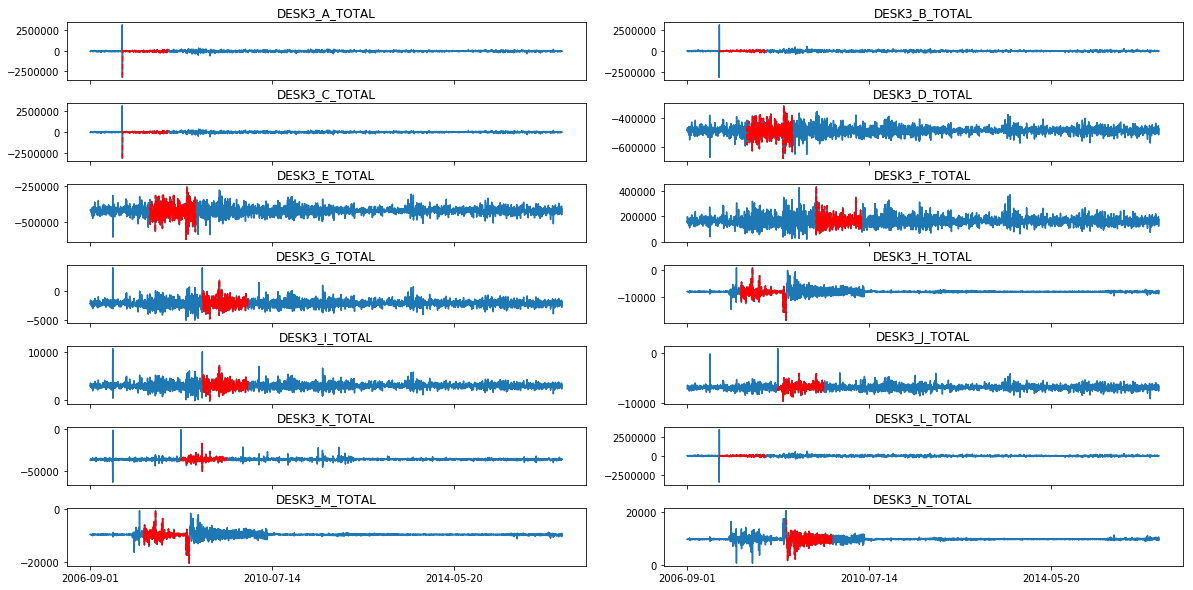

In [12]:
fig, axs = plt.subplots(int((len(Desk)+1)/2),2,figsize = (20,10), sharex=True)
fig.subplots_adjust(hspace = .4, wspace=.15)
axs = axs.ravel()
for i in range(len(Desk)):
    axs[i].set_title(Desk[i])
    axs[i].plot(PL_pd[PL_pd.columns[i]])
    axs[i].plot(PL_pd[sp_desk[Desk[i]][0]:sp_desk[Desk[i]][1]][PL_pd.columns[i]] , 'r--')
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(3))
plt.savefig('StreePeriodDesk.png')

## Enterprise Level Graph
-  Show graph of Stress Period at Enterprice Level and Save the Output as Png

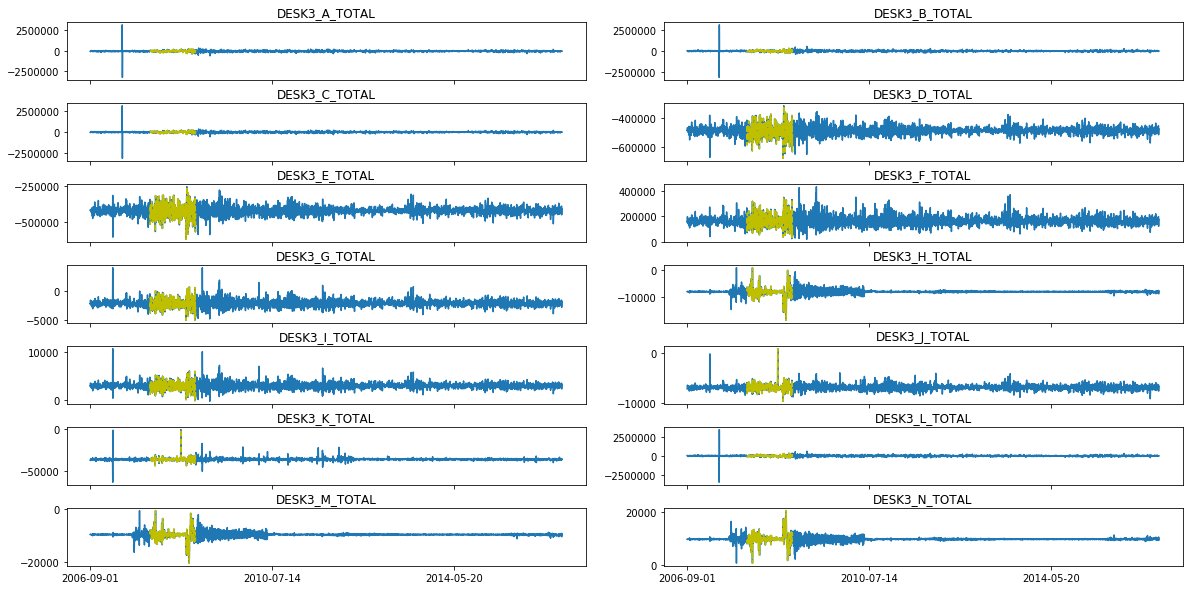

In [13]:
fig, axs = plt.subplots(int((len(Desk)+1)/2),2,figsize = (20,10), sharex=True)
fig.subplots_adjust(hspace = .4, wspace=.15)
axs = axs.ravel()
for i in range(len(Desk)):
    axs[i].set_title(Desk[i])
    axs[i].plot(PL_pd[PL_pd.columns[i]])
    axs[i].plot(PL_pd[sp_enterprise[Desk[1]][0]:sp_enterprise[Desk[1]][1]][PL_pd.columns[i]] , 'y--')
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(3))
plt.savefig('StreePeriodEnterprise.png')

# Output

In [14]:
Final_pd.to_csv('IMA_Result.csv')